In [ ]:
import os
import sys

# Go up one directory level to reach root
root_dir = os.path.dirname(os.getcwd())
os.chdir(root_dir)

# Add root to Python path
sys.path.insert(0, root_dir)

print(f"Current working directory: {os.getcwd()}")
print(f"Root directory added to path: {root_dir}")

In [ ]:
%load_ext autoreload
%autoreload 2
from functions._utils_ import *

In [ ]:
hirushu_dir = os.getcwd() + '/test_rawdata/Tamura/引き継ぎ/ヒルシュ'
hirushu_dir

raman_raw_dir = hirushu_dir + '/raman_raw'
hirsch_dir = {}
normal_dir = {}
other_dir = {}
for l in os.listdir(raman_raw_dir):
    if "hirsch" in l:
        hirsch_dir[l] = raman_raw_dir + '/' + l
        continue

    if "normal" in l:
        normal_dir[l] = raman_raw_dir + '/' + l
        continue

    other_dir[l] = raman_raw_dir + '/' + l

In [ ]:
hirsch_dfs = []
m = 1
n = 3
window_size = 50
tst_hirsch_df = None
tst_normal_df = None
for k in range(1, 4):
    csv_path = os.path.join(
        hirushu_dir, 'データ', 'merged_data_raw', f'Case{k}', 'hirsch', 'hirsch.csv')
    loader = RamanDataLoader(csv_path)
    df = loader.data
    processor = RamanNoiseProcessor(df)
    processed_df = processor.baselineAndGaussianNoise(window_size=window_size)
    if k == m:
        tst_hirsch_df = processed_df
    else:
        hirsch_dfs.append(processed_df)

normal_dfs = []
for k in range(1, 4):
    csv_path = os.path.join(
        hirushu_dir, 'データ', 'merged_data_raw', f'Case{k}', 'normal', 'normal.csv')
    loader = RamanDataLoader(csv_path)
    df = loader.data
    processor = RamanNoiseProcessor(df)
    processed_df = processor.baselineAndGaussianNoise(window_size=window_size)
    if k == n:
        tst_normal_df = processed_df
    else:
        normal_dfs.append(processed_df)

In [ ]:
labels = ["normal", "hirsch"]
region = (1000, 1800)  # Raman region of interest
# https://ramanspy.readthedocs.io/en/latest/preprocessing.html
# https://www.nature.com/articles/s41377-024-01394-5
# preprocess_steps_test = [
#         rp.preprocessing.misc.Cropper(region=region),
#         rp.preprocessing.despike.WhitakerHayes(),
#         MovingAverage(window_length=5),
#         rp.preprocessing.baseline.ModPoly(tol=0.01),
#         # rp.preprocessing.baseline.ASPLS(lam=1e5, tol=0.01),
#         rp.preprocessing.normalise.Vector(),
#         # SNV(),
#     ]

preprocess_steps_test = [
    rp.preprocessing.misc.Cropper(region=region),
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.denoise.SavGol(window_length=13, polyorder=3),
    # rp.preprocessing.baseline.ASPLS(),
    rp.preprocessing.baseline.ModPoly(tol=0.001),
    rp.preprocessing.normalise.Vector(),
    # SNV()   # Use SNV normalization as in the Readme
]

In [ ]:
train_hirsch = RamanPipeline().preprocess(
    dfs=hirsch_dfs,
    label=labels[1],
    region=region,
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=True
)

train_normal = RamanPipeline().preprocess(
    dfs=normal_dfs,
    label=labels[0],
    region=region,
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

In [7]:
# MODEL_SHORT = "SVC-linear"
# mlresult = ramanML.train_svc(disease_data=([train_hirsch["processed"]], labels[1]),
#                              normal_data=([train_normal["processed"]], labels[0]), param_search=True, test_size=0.4, SVC_model=ramanML.SVCMODEL(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced'))
ramanML = RamanML()
MODEL_SHORT = "RF"
mlresult = ramanML.train_rf(disease_data=([train_hirsch["processed"]], labels[1]),
                            normal_data=([train_normal["processed"]], labels[0]), param_search=True, test_size=0.3,
                            RF_model=ramanML.RFMODEL(n_estimators=200,           # More trees for stability
                                                     criterion="entropy",           # Or "entropy" for information gain
                                                     max_depth=10,
                                                     min_samples_split=5,
                                                     min_samples_leaf=5,
                                                     max_features="sqrt",        # Good default for classification
                                                     class_weight="balanced",    # Important for imbalanced classes
                                                     random_state=42,            # For reproducibility
                                                     n_jobs=-1,                  # Use all CPU cores
                                                     bootstrap=True,             # Default
                                                     oob_score=True,),)
print(f"training time: {round((mlresult['training_time']) / 60, 5)}")
print(mlresult["model"].get_params())

Best RF parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
training time: 0.97334
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [8]:
pprint(translate_confusion_matrix(
    mlresult["confusion_matrix"], labels), indent=2)
pprint(mlresult["classification_report"], indent=2)
print(
    f"CV Accuracy: {mlresult['cross_val_score'].mean():.3f} ± {mlresult['cross_val_score'].std():.3f}")

{'hirsch': {'hirsch': 33, 'normal': 0}, 'normal': {'hirsch': 0, 'normal': 30}}
('              precision    recall  f1-score   support\n'
 '\n'
 '      normal       1.00      1.00      1.00        30\n'
 '      hirsch       1.00      1.00      1.00        33\n'
 '\n'
 '    accuracy                           1.00        63\n'
 '   macro avg       1.00      1.00      1.00        63\n'
 'weighted avg       1.00      1.00      1.00        63\n')
CV Accuracy: 0.993 ± 0.020


In [9]:
test_hirsch_df = RamanPipeline().preprocess(
    dfs=[tst_hirsch_df],
    region=region,
    label=labels[1],
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

test_normal_df = RamanPipeline().preprocess(
    dfs=[tst_normal_df],
    region=region,
    label=labels[0],
    preprocessing_steps=preprocess_steps_test,
    visualize_steps=False
)

In [10]:
normal_spectra = [test_normal_df, ]
cancer_spectra = [test_hirsch_df, ]
test_spectra = [k["processed"] for k in normal_spectra + cancer_spectra]
true_labels = []
for k in cancer_spectra + normal_spectra:
    true_labels.extend(k["labels"])



In [11]:
# predict_data = ramanML.predict(
#     test_spectra=test_spectra,
#     # model = svc_data["model"]
# )

predict_data = ramanML.predict_with_threshold(
    test_spectra=test_spectra,
    positive_label=labels[1],
    # model = mlresult["model"],
    threshold=0.75,

)

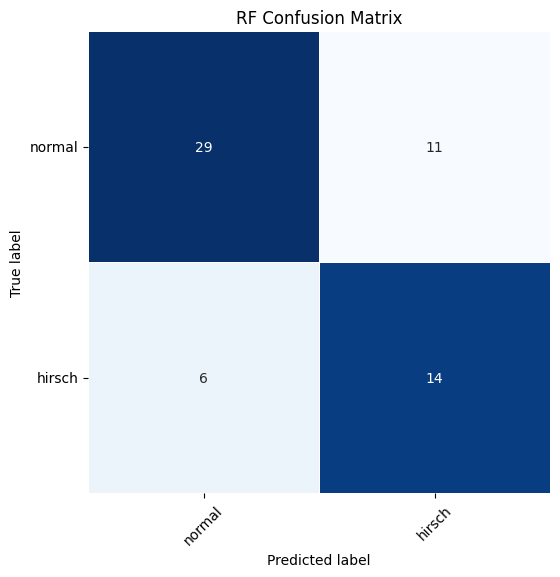

Predict Accuracy:
normal: 72.50%
hirsch: 70.00%


In [12]:
visualizer = RamanVisualizer(ramanML=ramanML,
                             labels=labels,)

predict_accuracy, plotdata = visualizer.confusion_matrix_heatmap(
    y_true=true_labels,          # true labels for test set
    y_pred=predict_data["y_pred"],  # predicted labels for test set
    # class names, e.g. ["benign", "cancer"]
    class_labels=labels,
    title=f"{MODEL_SHORT} Confusion Matrix",
    normalize=False,
    cmap="Blues",
    figsize=(8, 6),
    fmt="d",
)
print("Predict Accuracy:")
print("=====================================")
for i, (label, percentage) in enumerate(predict_accuracy.items()):
    print(f"{label}: {percentage:.2f}%")

Inspecting 1 random spectra...

Analyzing spectrum 1/1...
Predicting 1 test samples with 858 features.
Using stored data: 147 background samples, 1 test samples
Background data reduced to 30 samples
Computing SHAP values for 1 samples with 30 background samples...
Using TreeExplainer for RandomForest model...
Debug - Final types: expected_val=<class 'float'> (value: 0.49942193128984536)
Debug - sample_shap type: <class 'numpy.ndarray'>, shape: (858,)
Debug - test_sample type: <class 'numpy.ndarray'>, shape: (858,)
Debug: class_shap_values shape for hirsch: (858,)
Debug: class_shap_values type: <class 'numpy.ndarray'>
Debug: class_shap_values shape for normal: (858,)
Debug: class_shap_values type: <class 'numpy.ndarray'>


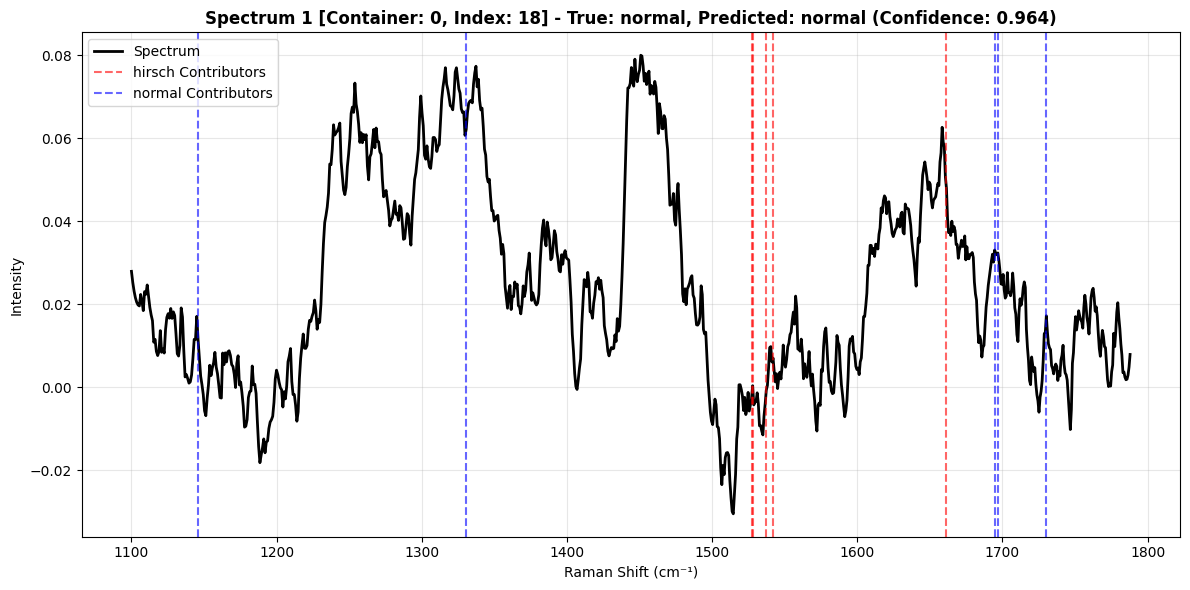

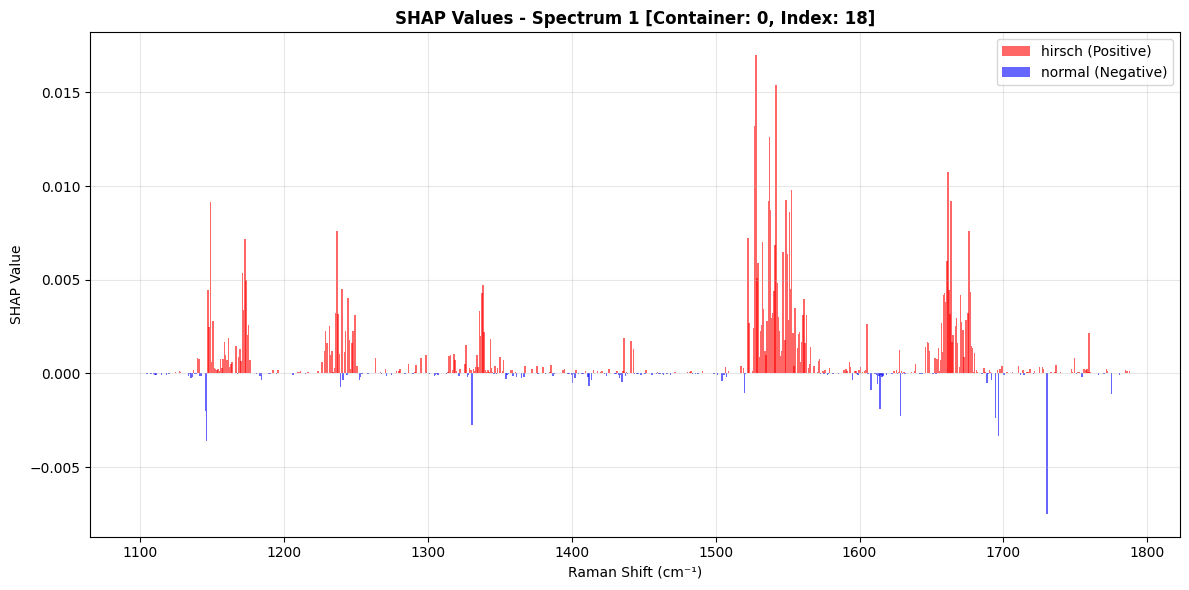

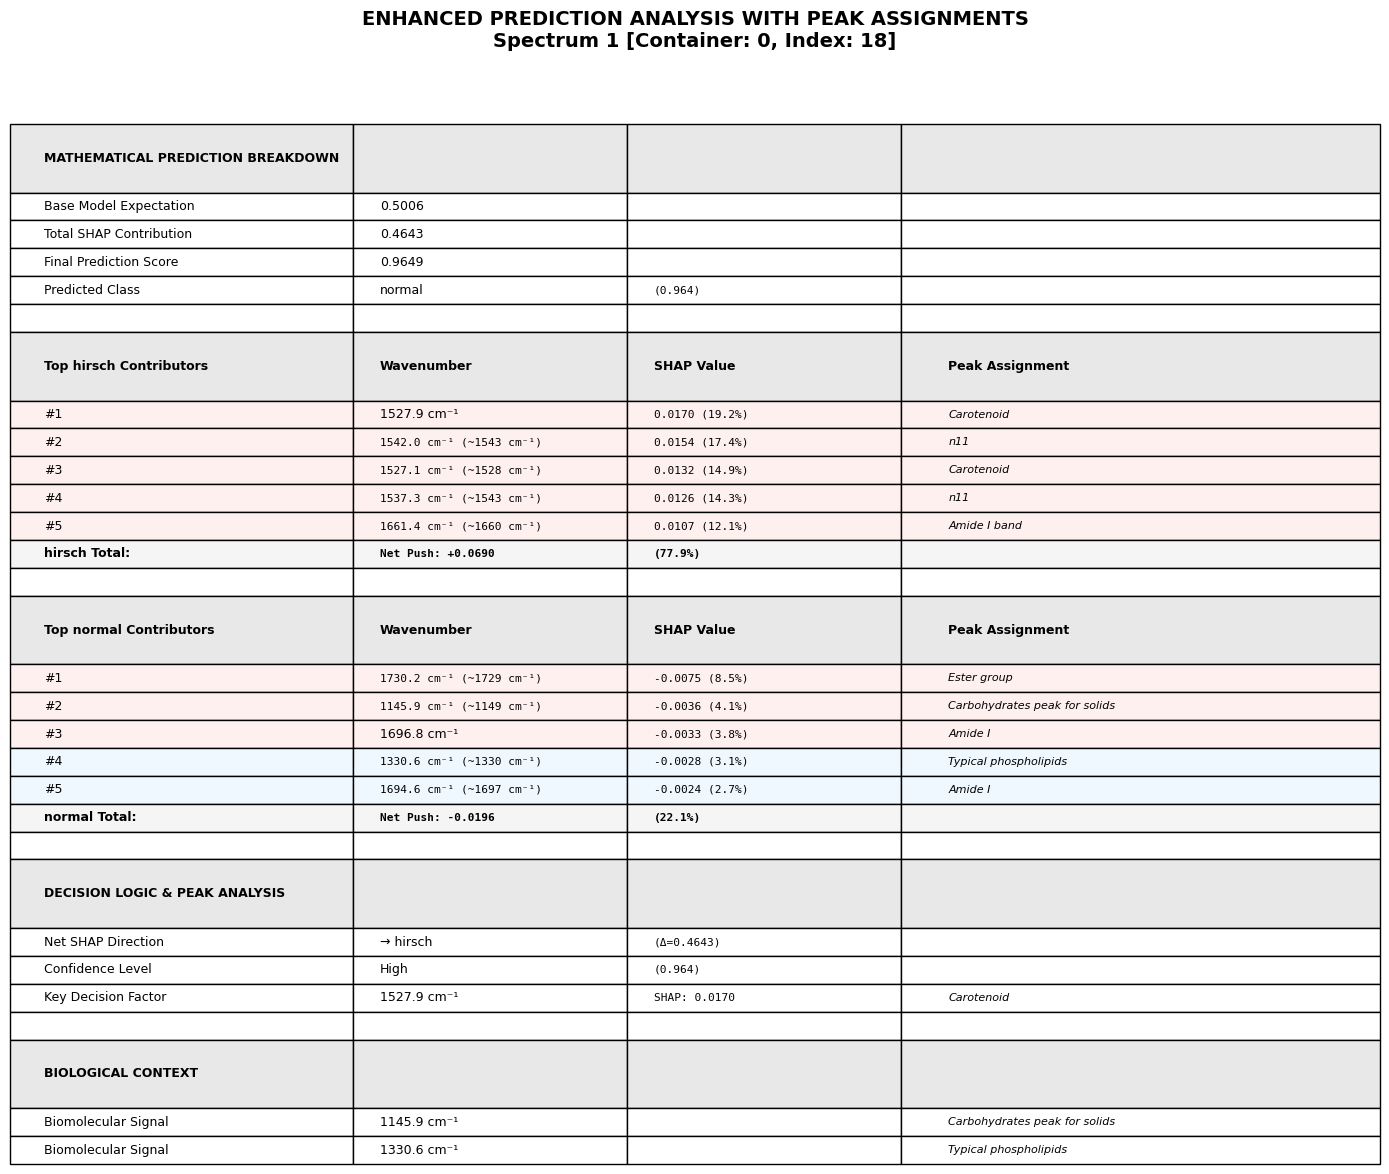

Spectrum 1 Summary [Container: 0, Index: 18]:
  True Label: normal
  Predicted: normal (Confidence: 0.964)
  Correct: Yes
  Top hirsch contributor: 1527.9 cm⁻¹ (SHAP: 0.0170)
  Top normal contributor: 1730.2 cm⁻¹ (SHAP: -0.0075)


In [18]:
inspect_shap = visualizer.inspect_random_spectra(
    n_samples=1,
    positive_label=labels[1],
    negative_label=labels[0],)